## Wykrywanie naczyń dna siatkówki oka

__Autorzy:__
 - Kacper Magnuszewski 151746, kacper.magnuszewski@student.put.poznan.pl
 - Tymoteusz Jagła 151811, tymoteusz.jagla@student.put.poznan.pl 

### Cel projektu
Napisany program ma za zadanie wykryć naczynia dna siatkówki oka na zdjęciu, po czym binarnie sklasyfikować każdy piksel zdjęcia (przedstawia żyłkę lub nie) w celu stworzenia maski. Maska ma określić położenie i bieg naczynek na dnie siatkówki. 

### Zastosowany język programowania i biblioteki
 Wykorzystany przez nas język programowania to Python. Projekt napisany jest przy użyciu interaktywnego Jupyter Notebook'a. 

 Do tego użyliśmy bibliotek:
   - OpenCV - Wczytanie i modyfikacja zdjęć
   - numpy - Obliczenia z wykorzystaniem tablic
   - matplotlib - Wyświetlenie zdjęć i efektów przetwarzania na wykresach
   - scikit-image - Filtrowanie i przetwarzanie zdjęcia

In [60]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mplt
import skimage.exposure as exp
import skimage.filters as filter

mplt.rcParams['figure.figsize'] = [20, 12]

### Wczytanie obrazu
Stworzyliśmy klasę Image, w której przechowujemy oryginalne zdjęcie, maskę z ręcznie oznaczonymi naczynkami, pole widzenia oddzielające obraz oka od tła oraz zdjęcie ze zmodyfikowanym parametrem gamma w celu lepszego wyróżnienia żyłek (rozjaśnienie tła, przyciemnienie naczynek).

In [61]:
IMAGE_PATHS = ["images/01_h.jpg",  "images/02_h.jpg",  "images/03_h.jpg",  "images/04_h.jpg",  "images/05_h.jpg"]
LABELED_PATHS = ["manual/01_h.tif",  "manual/02_h.tif",  "manual/03_h.tif",  "manual/04_h.tif",  "manual/05_h.tif"]
FOV_PATHS = ["fovmasks/01_h_mask.tif",  "fovmasks/02_h_mask.tif",  "fovmasks/03_h_mask.tif",  "fovmasks/04_h_mask.tif",  "fovmasks/05_h_mask.tif"]


class Image:
    def __init__(self, image, gammaCorrected, labeled, fov):
        self.image = image
        self.gammaCorrected = gammaCorrected
        self.labeled = labeled
        self.fov = fov


def read_single_image(imagePath, labeledPath, fovPath):
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_gamma_corrected = exp.adjust_gamma(image, 1.1)
    image_labeled = cv2.imread(labeledPath, cv2.IMREAD_GRAYSCALE)
    image_labeled[np.where(image_labeled > 0)] = 1
    image_fov = cv2.imread(fovPath, cv2.IMREAD_GRAYSCALE)

    return Image(image, image_gamma_corrected, image_labeled, image_fov)


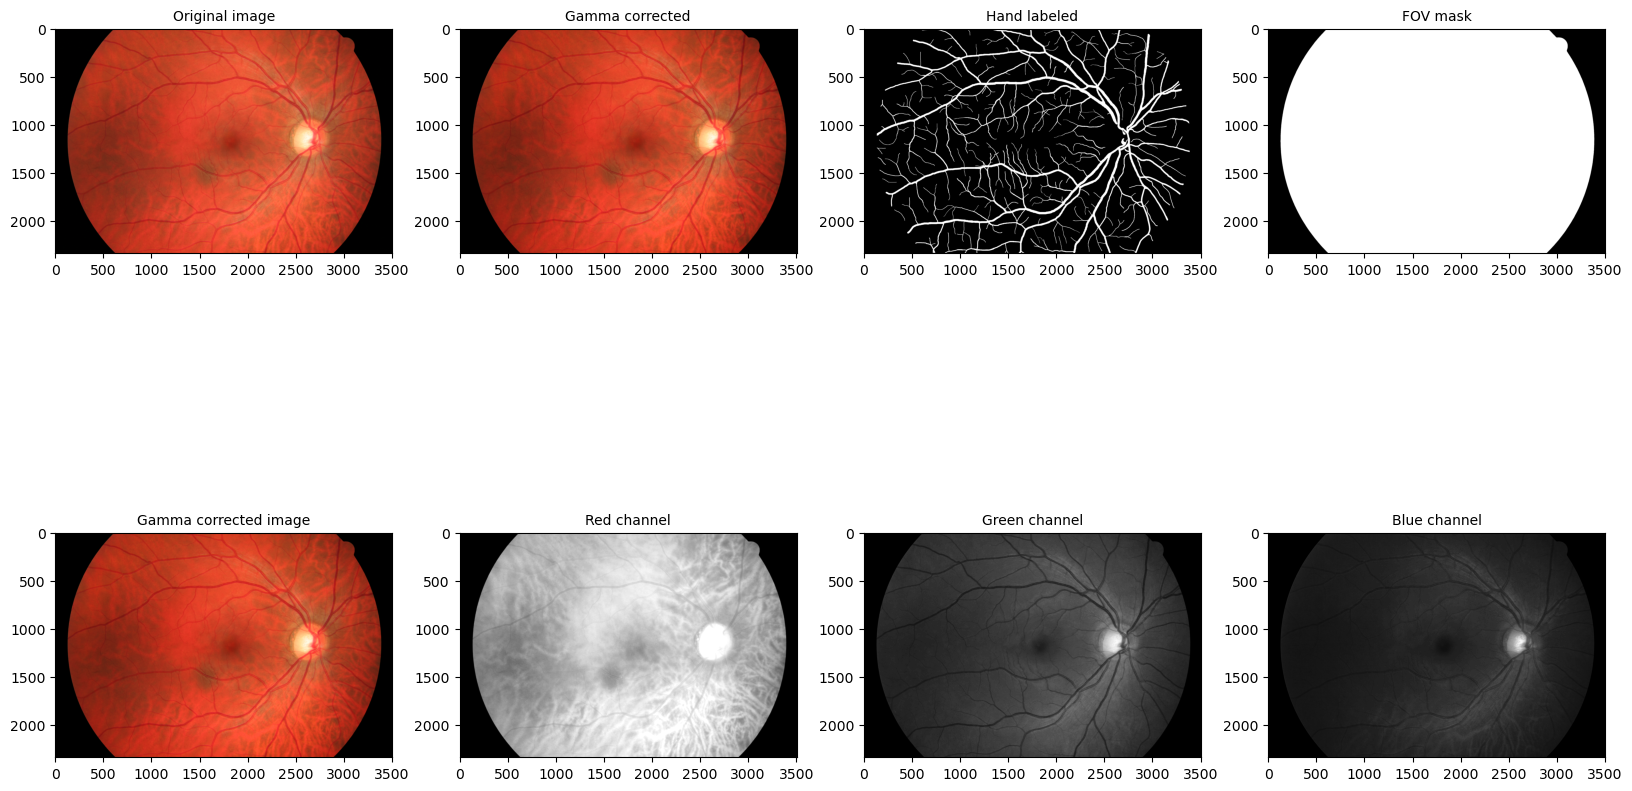

In [62]:
images = []

for image_path, labeled_path, fov_path in zip(IMAGE_PATHS, LABELED_PATHS, FOV_PATHS):
    images.append(read_single_image(image_path, labeled_path, fov_path))

image = images[0].image
image_gamma_corrected = images[0].gammaCorrected
image_labeled = images[0].labeled
image_fov = images[0].fov

image_red = image_gamma_corrected[:, :, 0]
image_green = image_gamma_corrected[:, :, 1]
image_blue = image_gamma_corrected[:, :, 2]

fig, ax = plt.subplots(2, 4)
ax[0][0].set_title("Original image", fontdict = {'fontsize': 10})
ax[0][1].set_title("Gamma corrected", fontdict = {'fontsize': 10})
ax[0][2].set_title("Hand labeled", fontdict = {'fontsize': 10})
ax[0][3].set_title("FOV mask", fontdict = {'fontsize': 10})
ax[0][0].imshow(image)
ax[0][1].imshow(image_gamma_corrected)
ax[0][2].imshow(image_labeled, cmap = "gray")
ax[0][3].imshow(image_fov, cmap = "gray")

ax[1][0].set_title("Gamma corrected image", fontdict = {'fontsize': 10})
ax[1][1].set_title("Red channel", fontdict = {'fontsize': 10})
ax[1][2].set_title("Green channel", fontdict = {'fontsize': 10})
ax[1][3].set_title("Blue channel", fontdict = {'fontsize': 10})
ax[1][0].imshow(image_gamma_corrected)
ax[1][1].imshow(image_red, cmap = "gray")
ax[1][2].imshow(image_green, cmap = "gray")
ax[1][3].imshow(image_blue, cmap = "gray")

### Przetwarzanie obrazu
Następnym krokiem w przetwarzaniu obrazu było przefiltrowanie go w celu odróżnienia naczynek od tła obrazu. W tym celu najpierw zastosowaliśmy filtr Frangi'ego. Nie dał on jednak porządanych efektów. W naszym przypadku nie oddzielał skutecznie tła od naczynek nawet przy modyfikacji parametru gamma zdjęcia. Postanowiliśmy użyć fitra Sato, który dał dużo lepsze efekty w odróżnianiu naczynek od tła. Następnie wygenerowaliśmy maskę zdjęcia stodując odpowiednie progi, dzięki którym określaliśmy czy dany piksel przedstawia naczynko, tło, czy zakłócenie w działaniu filtra. Dodatkowo usunęliśmy obramówkę zdjęcia przyrównując ją do wcześniej zapisanego w klasie pola widzenia.

In [63]:
def filterImage(image):
    filtered = filter.sato(image)

    min_val = np.min(filtered)
    max_val = np.max(filtered)
    filtered = (filtered - min_val) / (max_val - min_val)

    return filtered


def equalize(image):
    equalized = exp.equalize_adapthist(image)
    
    return equalized


def generateMask(image, fov):
    generated_mask = np.zeros(image.shape)
    generated_mask[np.where(image > filter.threshold_local(image, block_size = 3, method = 'mean'))] = 1
    generated_mask[np.where(image < filter.threshold_mean(image) * 2)] = 0
    generated_mask[np.where(fov == 0 )] = 0

    return generated_mask

### Przedstawienie wyników
Poniżej przedstawiliśmy każdy krok przetwarzania obrazu w celu oznaczenia na nim naczynek. Najpierw zostało pokazane zdjęcie po nałożeniu filtra i znormalizowaniu. Następnie uzyskany obraz rozjaśniliśmy, a z niego wygenerowaliśmy maskę. Ostatnie dwa zdjęcia przedstawiają ręcznie oznaczone żyłki dla porównania z maską wygenerowaną przez program oraz efekt końcowy przetwarzania, czyli oryginalne zdjęcie z nałożoną stworzoną maską.

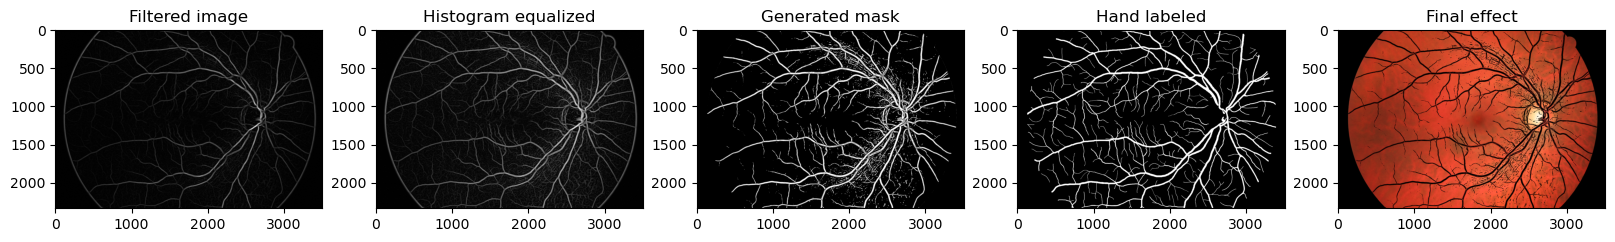

In [64]:
filtered = filterImage(image_green)
plt.subplot(151)
plt.title("Filtered image")
plt.imshow(filtered, cmap="gray");

equalized = equalize(filtered)
plt.subplot(152)
plt.title("Histogram equalized")
plt.imshow(equalized, cmap="gray")

generated_mask = generateMask(equalized, image_fov)
plt.subplot(153)
plt.title("Generated mask")
plt.imshow(generated_mask, cmap="gray");

plt.subplot(154)
plt.title("Hand labeled")
plt.imshow(image_labeled, cmap = "gray")

image_final = image
image_final[np.where(generated_mask == 1)] = 0
plt.subplot(155)
plt.title("Final effect")
plt.imshow(image_final)

### Badanie poprawności algorytmu
Na koniec przyrównaliśmy wyniki działania naszego programu do maski z ręcznie oznaczonymi naczynkami i dokonaliśmy testów:
  - Trafność (Accuracy)
  - Czułość (Sensitivity)
  - Swoistość (Specificity)

Dodatkowo wyznaczyliśmy dwie macierze przedstawiające wszystkie piksele oznaczone fałszywie ujemnie i fałszywie dodatnio.

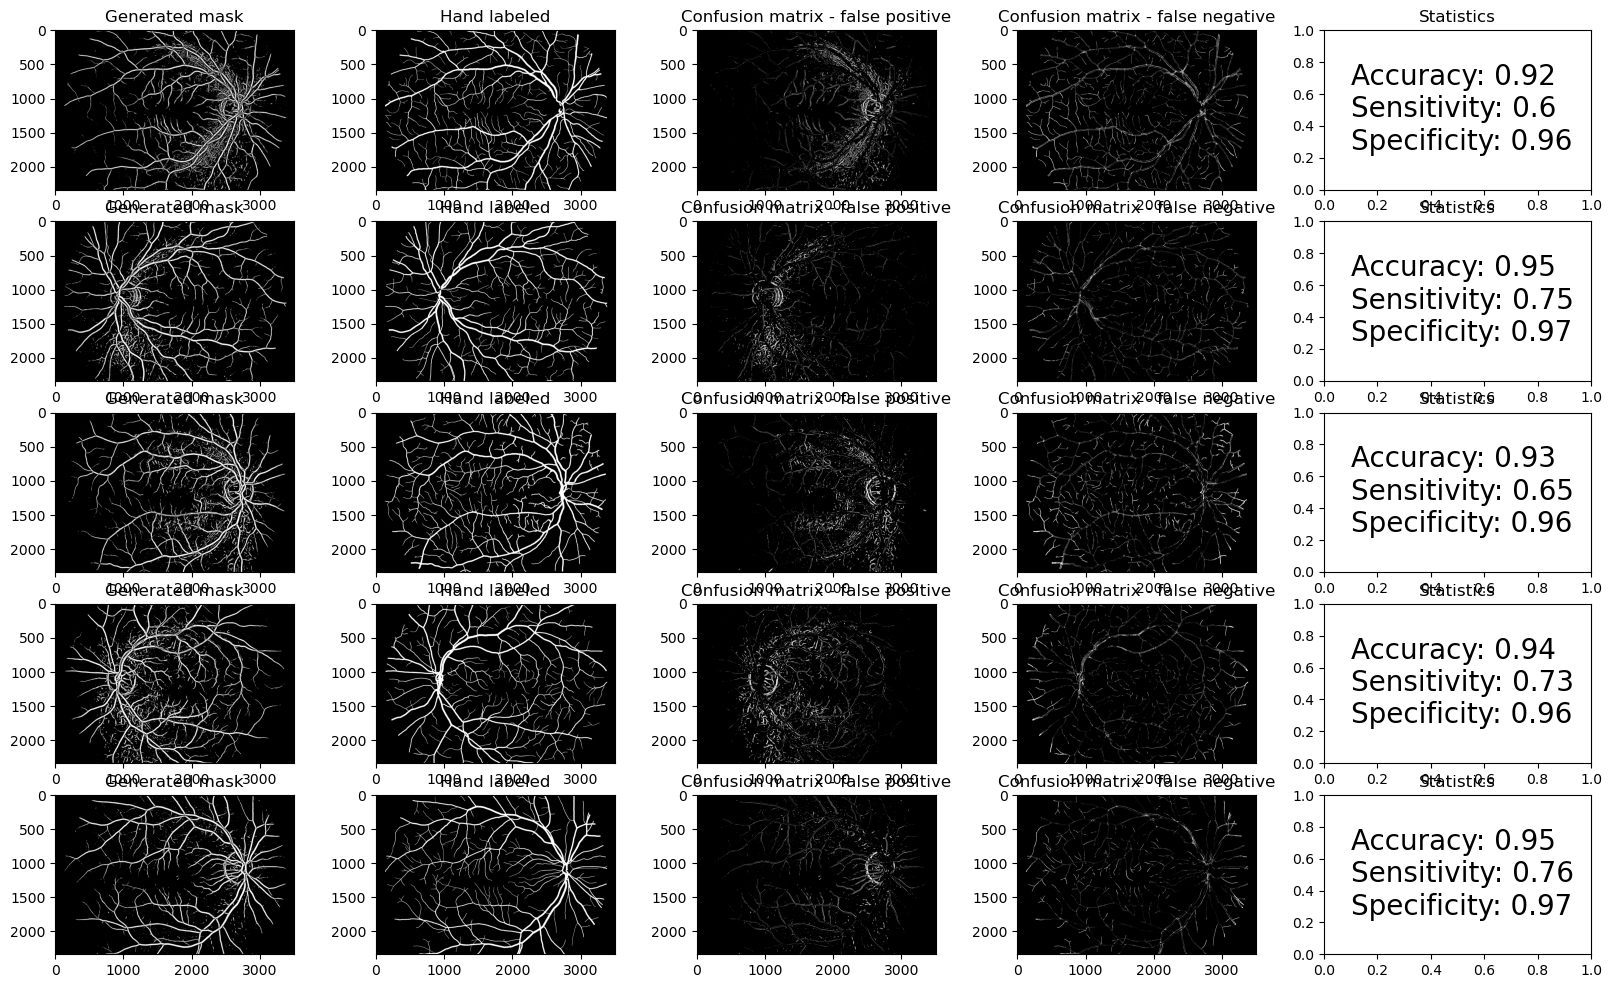

In [65]:
fig, axs = plt.subplots(len(images), 5)
generated_masks = []

for image in images:
    generated_masks.append((generateMask(equalize(filterImage(image.image[:, :, 1])), image.fov), image.labeled, image.fov))

for i, maskTuple in enumerate(generated_masks):
    mask, labeled, fov = maskTuple
    confusion_matrix_fp = np.zeros(mask.shape)
    confusion_matrix_fn = np.zeros(mask.shape)
    confusion_matrix_fp[np.where(mask > labeled)] = 1
    confusion_matrix_fn[np.where(mask < labeled)] = 1

    true_positive = np.sum(labeled[np.where(mask == 1)] == 1)
    true_negative = np.sum(labeled[np.where(mask == 0)] == 0)
    false_positive = np.sum(labeled[np.where(mask == 1)] == 0)
    false_negative = np.sum(labeled[np.where(mask == 0)] == 1)

    accuracy = round((true_positive + true_negative) / (true_positive + false_positive + false_negative + true_negative), 2)
    sensitivity = round(true_positive / (true_positive + false_negative + 1), 2)
    specificity = round(true_negative / (false_positive + true_negative + 1), 2)

    axs[i][0].set_title("Generated mask")
    axs[i][0].imshow(mask, cmap = "gray")

    axs[i][1].set_title("Hand labeled")
    axs[i][1].imshow(labeled, cmap = "gray")

    axs[i][2].set_title("Confusion matrix - false positive")
    axs[i][2].imshow(confusion_matrix_fp, cmap = "gray")

    axs[i][3].set_title("Confusion matrix - false negative")
    axs[i][3].imshow(confusion_matrix_fn, cmap = "gray")

    axs[i][4].set_title("Statistics")
    axs[i][4].set(xlim =(0, 1), ylim =(0, 1)) 
    axs[i][4].text(0.1, 0.25, f"Accuracy: {accuracy}\nSensitivity: {sensitivity}\nSpecificity: {specificity}", fontsize = 20)


plt.show()